In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import yaml
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

In [2]:
with open('db_default_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='donors',
        password=config["pass"],
        port=config["port"],
    )
    engine_donors = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [ ]:
import RecallAdjuster as ra

In [59]:
import importlib
importlib.reload(ra)

del(myRA)

In [57]:
# Duplicates in the old entity_demos table, so just grab distinct ones
# (also updated creation script to ensure this as well)

engine_donors.execute("CREATE TABLE kit_bias_exp.entity_demos_distinct AS SELECT DISTINCT * FROM hemank_bias_2way_dates.entity_demos;")
engine_donors.execute("CREATE INDEX ON kit_bias_exp.entity_demos_distinct(entity_id, as_of_date)")
engine_donors.execute("COMMIT;")


In [58]:
pd.read_sql("""
WITH ed_cnts AS (
    SELECT entity_id, COUNT(*) AS num FROM kit_bias_exp.entity_demos_distinct GROUP BY 1
)
SELECT num, COUNT(*) FROM ed_cnts GROUP BY 1 ORDER BY 1
""", engine_donors)

,num,count
0,1,329494


In [64]:
engine_donors.execute("CREATE SCHEMA kit_bias_dedupe;")
engine_donors.execute("""
    CREATE TABLE kit_bias_dedupe.model_adjustment_results_plevel 
    AS SELECT * FROM kit_bias_exp.model_adjustment_results_plevel LIMIT 0;
""")
engine_donors.execute("""
    CREATE TABLE kit_bias_dedupe.composite_results_plevel 
    AS SELECT * FROM kit_bias_exp.composite_results_plevel LIMIT 0;
""")
engine_donors.execute("COMMIT;")

In [67]:
# Re-running the recall adjustments (this takes a bit of time...)

date_pairs_all = [
 ('2011-03-01', '2011-03-01'),
 ('2011-03-01', '2011-07-01'),
 ('2011-05-01', '2011-05-01'),
 ('2011-05-01', '2011-09-01'),
 ('2011-07-01', '2011-07-01'),
 ('2011-07-01', '2011-11-01'),
 ('2011-09-01', '2011-09-01'),
 ('2011-09-01', '2012-01-01'),
 ('2011-11-01', '2011-11-01'),
 ('2011-11-01', '2012-03-01'),
 ('2012-01-01', '2012-01-01'),
 ('2012-01-01', '2012-05-01'),
 ('2012-03-01', '2012-03-01'),
 ('2012-03-01', '2012-07-01'),
 ('2012-05-01', '2012-05-01'),
 ('2012-05-01', '2012-09-01'),
 ('2012-07-01', '2012-07-01'),
 ('2012-07-01', '2012-11-01'),
 ('2012-09-01', '2012-09-01'),
 ('2012-09-01', '2013-01-01')
 ]

for dp_idx in range(10):
    date_pairs = [ date_pairs_all[2*dp_idx], date_pairs_all[2*dp_idx+1] ]
    print(date_pairs)

    myRA = ra.RecallAdjuster(
            engine=engine_donors,
            pg_role='kit',
            schema='kit_bias_exp',
            experiment_hashes='a33cbdb3208b0df5f4286237a6dbcf8f',
            date_pairs=date_pairs,
            list_sizes=[1000],
            entity_demos='kit_bias_exp.entity_demos_distinct',
            demo_col='plevel'
    )
    
    engine_donors.execute("""
        INSERT INTO kit_bias_dedupe.model_adjustment_results_plevel 
        SELECT * FROM kit_bias_exp.model_adjustment_results_plevel;
    """)
    
    engine_donors.execute("""
        INSERT INTO kit_bias_dedupe.composite_results_plevel 
        SELECT * FROM kit_bias_exp.composite_results_plevel;
    """)
    
    engine_donors.execute("COMMIT;")

[('2011-03-01', '2011-03-01'), ('2011-03-01', '2011-07-01')]
[('2011-05-01', '2011-05-01'), ('2011-05-01', '2011-09-01')]
[('2011-07-01', '2011-07-01'), ('2011-07-01', '2011-11-01')]
[('2011-09-01', '2011-09-01'), ('2011-09-01', '2012-01-01')]
[('2011-11-01', '2011-11-01'), ('2011-11-01', '2012-03-01')]
[('2012-01-01', '2012-01-01'), ('2012-01-01', '2012-05-01')]
[('2012-03-01', '2012-03-01'), ('2012-03-01', '2012-07-01')]
[('2012-05-01', '2012-05-01'), ('2012-05-01', '2012-09-01')]
[('2012-07-01', '2012-07-01'), ('2012-07-01', '2012-11-01')]
[('2012-09-01', '2012-09-01'), ('2012-09-01', '2013-01-01')]


In [144]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_dedupe.model_adjustment_results_plevel
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_not_highest_to_highest AS recall_not_highest_to_highest,
       r.base_frac_not_highest AS frac_not_highest,
       r.base_frac_highest AS frac_highest
FROM kit_bias_dedupe.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
       r.adj_frac_not_highest AS frac_not_highest,
       r.adj_frac_highest AS frac_highest
FROM kit_bias_dedupe.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
       r.adj_frac_not_highest AS frac_not_highest,
       r.adj_frac_highest AS frac_highest
FROM kit_bias_dedupe.model_adjustment_results_plevel r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_not_highest_to_highest,
      frac_not_highest,
      frac_highest
FROM kit_bias_dedupe.composite_results_plevel
WHERE train_end_time > past_train_end_time
;
"""

In [145]:
ts_df3 = pd.read_sql(sql, engine_donors)

In [77]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([1,3,5,7,9,11])  # every month
months_fmt = mdates.DateFormatter('%b %y')

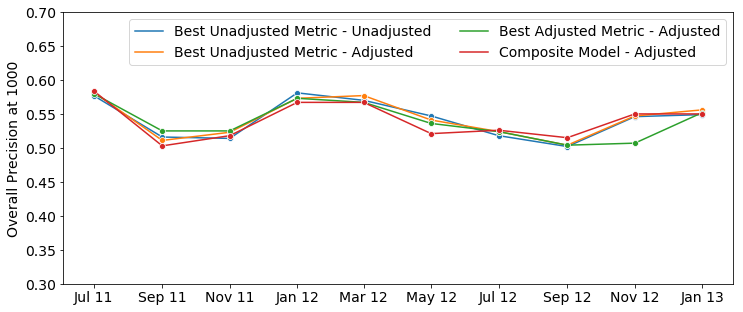

In [146]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=14)

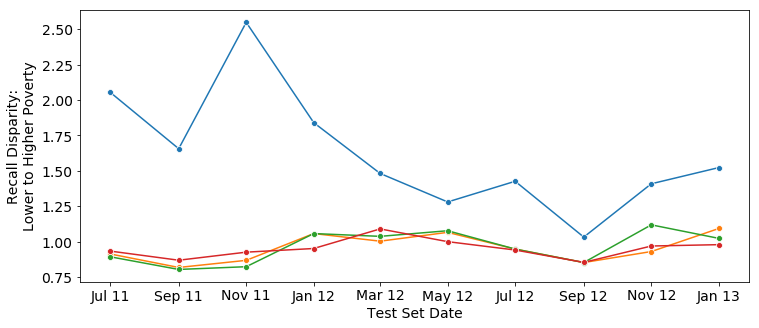

In [79]:

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_not_highest_to_highest', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity:\nLower to Higher Poverty', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.get_legend().remove()

In [74]:
ts_df3['dataset'] = 'Education Crowdfunding'

comp_df = ts_df3.rename(
    {'recall_not_highest_to_highest': 'recall_disp', 
     'frac_not_highest': 'frac_grp1', 
     'frac_highest': 'frac_grp2'
    }, axis='columns')

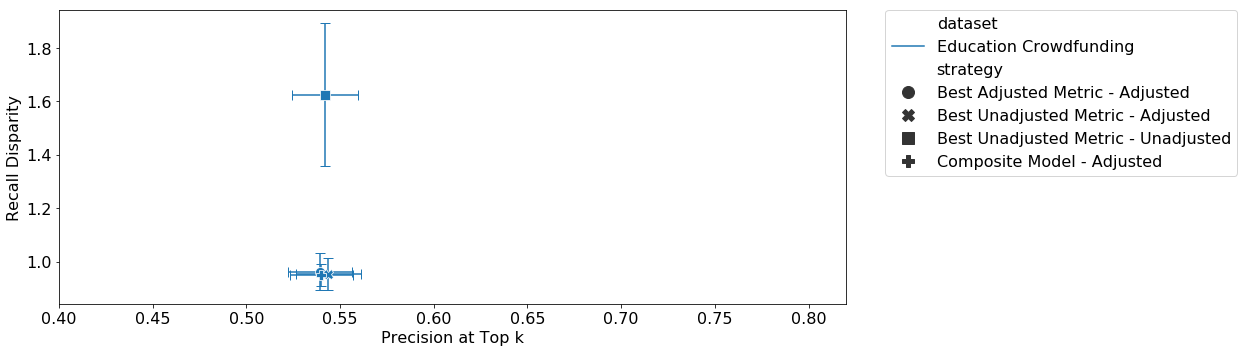

In [80]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

In [136]:
ts_df3['strategy'] = ts_df3['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

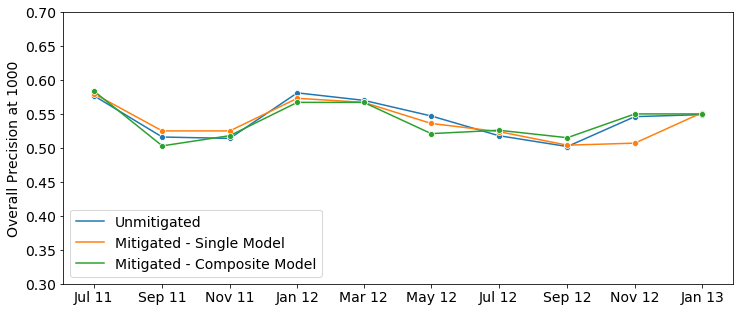

In [140]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14, loc='lower left')

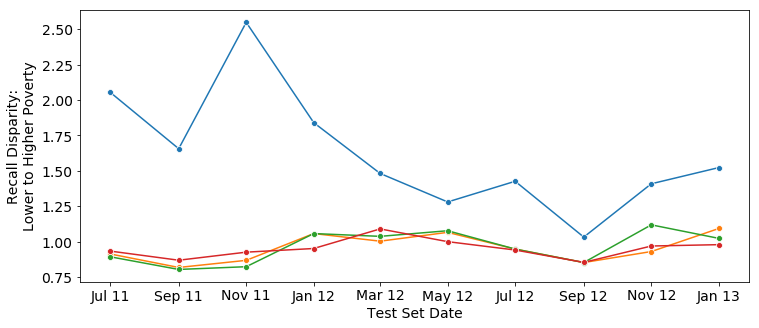

In [147]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='recall_not_highest_to_highest', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity:\nLower to Higher Poverty', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.get_legend().remove()

In [143]:
ts_df3.to_csv('donors_povery_2way_bias.csv', index=False)